In [131]:

import os
import numpy as np
import cv2
import math

unipen_root = "../../data/handwriting/Unipen/train_r01_v07/include"

data_providers = os.listdir(unipen_root)

for data_provider in data_providers:
    print(f"Looking at provider {data_provider}")
    data_provider_path = os.path.join(unipen_root, data_provider)
    data_path = os.path.join(data_provider_path, "data")

    if not os.path.exists(data_path):
        print(f"Data provider {data_provider} without data")
        continue

    doc_files = [filename for filename in os.listdir(data_provider_path) if filename != "data"]
    print(f"Doc files: {doc_files}")
    print(f"Stroke files: {os.listdir(data_path)}")
    

Looking at provider abm
Doc files: ['abm0.doc']
Stroke files: ['ca0.dat', 'ibo0.dat', 'sm0.dat', 'wz0.dat']
Looking at provider aga
Doc files: []
Stroke files: ['amywldrp.dat', 'annzchrl.dat', 'crlmtchl.dat', 'dawnmrsh.dat', 'drdvlllb.dat', 'elsbthey.dat', 'greghunt.dat', 'jamesmor.dat', 'jhnshrly.dat', 'lzbthwht.dat', 'mlssdrry.dat', 'nikkshmn.dat', 'scttjyns.dat', 'shrncrtr.dat']
Looking at provider anj
Doc files: ['anj.doc', 'anj.lex']
Stroke files: ['g9303.dat', 'g9304.dat', 'g9312.dat', 'g9313.dat', 'g9314.dat', 'g9318.dat']
Looking at provider apa
Doc files: ['app.doc']
Stroke files: ['apa00', 'apa01', 'apa02', 'apa03', 'apa04', 'apa09', 'apa10', 'apa12', 'apa13', 'apa14', 'apa15', 'apa16', 'apa19', 'apa20']
Looking at provider apb
Doc files: ['app.doc']
Stroke files: ['apb02', 'apb04', 'apb05', 'apb06', 'apb07', 'apb08', 'apb09', 'apb10', 'apb12', 'apb13', 'apb14', 'apb15', 'apb16', 'apb17', 'apb18', 'apb20', 'apb21', 'apb22', 'apb23', 'apb24', 'apb25', 'apb27', 'apb28', 'apb29'

In [132]:
from enum import Enum
class UnipenKeywords(Enum):
    # Config-related
    X_DIM = "X_DIM"
    Y_DIM = "Y_DIM"
    X_POINTS_PER_INCH = "X_POINTS_PER_INCH"
    Y_POINTS_PER_INCH = "Y_POINTS_PER_INCH"
    X_POINTS_PER_MM = "X_POINTS_PER_MM"
    Y_POINTS_PER_MM = "Y_POINTS_PER_MM"

    POINTS_PER_SECOND = "POINTS_PER_SECOND"
    COORD = "COORD"

    # Stroke-related
    PEN_UP = "PEN_UP"
    PEN_DOWN = "PEN_DOWN"
    START_BOX = "START_BOX"

In [133]:
import re

class UnipenHandler():
    handler_root: str
    strokes: list[list[int, int, bool]]

    COMMAND_PATTERN = r"^\.(\w*) ?(.*)$"

    def __init__(self, handler_root: str):
        self.handler_root = handler_root
        self.strokes = []

    def process_doc(self):
        """Process the documentation of this Unipen handler, preparing helpers to decipher the stroke data files.
        The specific handler prepare its config there"""
        raise NotImplementedError

    def get_config_for_datafile(self, datafile_path: str) -> dict:
        """Get the configuration for the given data file. Specific to handler type."""
        raise NotImplementedError
    
    def search_values_in_file(self, filepath: str, search_keys: set[str], throw_on_missing: bool) -> dict:
        """Helper function.
        Search the given values inside of the file. Return every match in a dictionnary
        The function will either return empty values for missing keys, or throw an exception"""
        result_dict = {}
        found_keys = set()
        
        with open(filepath, "rt") as f:

            for line in f.readlines():
                command_match = re.match(UnipenHandler.COMMAND_PATTERN, line)
                if command_match:
                    if command_match.group(1) in search_keys:
                        key = command_match.group(1)
                        values = command_match.group(2).strip()
                        if " " in values:
                            values = values.split(" ")
                        found_keys.add(key)
                        try:
                            result_dict[key].extend(values)
                        except KeyError:
                            result_dict[key] = [*values]
        
        set_diff = search_keys-found_keys
        if len(set_diff) > 0:
            error = f"Missing key values {set_diff} on file {filepath}"
            if throw_on_missing:
                raise Exception(error)
            else:
                print(error)
        
        return result_dict

    def create_strokes(self): 
        """In single doc format, we can open the 'data' folder and expect files to be strokes / folder of files"""
        data_folder = os.path.join(self.handler_root, "data")
        self.scan_data_folder(data_folder)
    
    def scan_data_folder(self, data_folder: str):
        """Scan a data folder in search of stroke files. In case of nested folder, scan nested folders"""
        print(f"Scanning {data_folder}")
        for filename in os.listdir(data_folder):
            filepath = os.path.join(data_folder, filename)
            if os.path.isdir(filepath):
                self.scan_data_folder(filepath)
            elif os.path.isfile(filepath):
                strokes = self.read_stroke_file(filepath)
                self.strokes.extend(strokes)

    def end_stroke(self, stroke: list, config: dict) -> list:
        """End a stroke and register if it is not empty.
        Return an empty stroke: Either the empty stroke in input or a new empty array"""
        if len(stroke) > 0:
            processed_stroke = self.process_stroke(np.array(stroke), config)
            self.strokes.append(processed_stroke)
            return []
        else:
            return stroke

    def read_stroke_file(self, filepath: str) -> list[tuple[int, int, bool]]:
        """Read a stroke file and return the list as a (x, y, penUp) signal"""
        configuration = self.get_config_for_datafile(filepath)
        coord_config: list = configuration[UnipenKeywords.COORD.value]

        idx, idy = coord_config.index("X"), coord_config.index("Y")

        #Read the line iteratively, line by line. Check if line is an instruction (.INSTRUCTION). If not, try to retrieve coordinates.
        strokes = []
        with open(filepath, "rt") as f:
            #Start at the first PEN instruction
            is_started = False
            pen_down = False
            current_stroke = []
            for line in f:
                line = line.rstrip().strip()
                
                #Gap
                if is_started and not line:
                    current_stroke = self.end_stroke(current_stroke, configuration)
                    continue

                command_match = re.match(UnipenHandler.COMMAND_PATTERN, line)
                if command_match:
                    match command_match.group(1):
                        #the penup signal is encoded in the last value of the stroke
                        case UnipenKeywords.PEN_UP.value:
                            is_started = True
                            pen_down = False
                            if len(current_stroke) > 0:
                                current_stroke[-1][2] = True
                        case UnipenKeywords.PEN_DOWN.value:
                            is_started = True
                            pen_down = True
                            #Well, some providers (anj) put a pen down WITHOUT a pen up, so we have to add the penup signal anyway.
                            if len(current_stroke) > 0:
                                current_stroke[-1][2] = True
                        case _:
                            continue
                else:
                    if not is_started or line.startswith("#"):
                        continue
                    
                    # Not empty line and not command: Assume coordinate line.
                    coords = line.strip().split()

                    x, y = int(coords[idx]), int(coords[idy])
                    if x==0 and y==0:
                        current_stroke = self.end_stroke(current_stroke, configuration)
                    else:
                        # Register points if and only if pen is down.
                        if pen_down:
                            current_stroke.append([x, y, False])

        #Add last current stroke
        self.end_stroke(current_stroke, configuration)

        return strokes
    
    def process_stroke(self, stroke: list[tuple[int, int, bool]], config: dict):
        """Apply post processing to the strokes
        Config: Configuration of the stroke, especially containing spatial info (DPI, PPI, etc) and spatial info (Points per seconds)"""
        align_strokes = True
        start_padding = 2

        #Y axis is inversed between plotting and signal
        max_y = max(stroke[:, 1])
        stroke[:, 1] = max_y - stroke[:, 1]

        #Alignement / padding
        if align_strokes:
            min_x = min(stroke[:, 0])
            stroke[:, 0] -= (min_x - start_padding)

            min_y = min(stroke[:, 1])
            stroke[:, 1] -= (min_y - start_padding)

        #TODO
        # Frequency adjustment

        #TODO
        #Pix distance adjustment

        return stroke

In [134]:
import re

class SingleDocFileHandler(UnipenHandler):
    """This handler manages Unipen provider with a single data file and a data/ folder containing strokes.
    If a or multiple lex file exist, ignore them"""
    config: dict

    
    def __init__(self, handler_root: str):
        super().__init__(handler_root)

        self.process_doc()

    def process_doc(self):
        """Process the documentation of this Unipen handler, preparing helpers to decipher the stroke data files"""
        #Retrieve single doc file
        files = os.listdir(self.handler_root)
        doc_candidates = [file for file in files if file.endswith(".doc")]
        if len(doc_candidates) != 1:
            raise Exception(f"Provider {self.handler_root}: Expected one doc file, found {doc_candidates}")

        doc_file = doc_candidates[0]

        #Parse doc file in order to find the data required to interpret the stroke
        required_search_values = set([UnipenKeywords.POINTS_PER_SECOND.value, UnipenKeywords.COORD.value])
        opt_search_values = set([
            UnipenKeywords.X_DIM.value, UnipenKeywords.Y_DIM.value,
            UnipenKeywords.X_POINTS_PER_INCH.value, UnipenKeywords.Y_POINTS_PER_INCH.value, 
            UnipenKeywords.X_POINTS_PER_MM.value, UnipenKeywords.Y_POINTS_PER_MM.value, 
        ])

        doc_filepath = os.path.join(self.handler_root, doc_file)
        self.config = {}
        self.config.update(self.search_values_in_file(doc_filepath, required_search_values, throw_on_missing=True))
        self.config.update(self.search_values_in_file(doc_filepath, opt_search_values, throw_on_missing=False))
        

    def get_config_for_datafile(self, datafile_path: str) -> dict:
        """Simple: In single doc mode the configuration is always the same"""
        return self.config

In [135]:
from pathlib import Path

class MultiDocFileHandler(UnipenHandler):
    """This handler manages Unipen provider with multiple doc files and a data/ folder containing strokes.
    It parses every config file and assumes that the data folder will be related to the doc files.
    If a or multiple lex file exist, ignore them"""
    configs: dict
    
    def __init__(self, handler_root: str):
        super().__init__(handler_root)

        self.process_doc()

    def process_doc(self):
        """Process the documentation of this Unipen handler, preparing helpers to decipher the stroke data files"""
        files = os.listdir(self.handler_root)
        doc_files = [file for file in files if file.endswith(".doc")]

        self.configs = {}

        for doc_file in doc_files:
            #Parse doc file in order to find the data required to interpret the stroke
            required_search_values = set([UnipenKeywords.POINTS_PER_SECOND.value, UnipenKeywords.COORD.value])
            opt_search_values = set([
                UnipenKeywords.X_DIM.value, UnipenKeywords.Y_DIM.value,
                UnipenKeywords.X_POINTS_PER_INCH.value, UnipenKeywords.Y_POINTS_PER_INCH.value, 
                UnipenKeywords.X_POINTS_PER_MM.value, UnipenKeywords.Y_POINTS_PER_MM.value, 
            ])

            doc_filepath = os.path.join(self.handler_root, doc_file)

            config_file = {}
            
            config_file.update(self.search_values_in_file(doc_filepath, required_search_values, throw_on_missing=True))
            config_file.update(self.search_values_in_file(doc_filepath, opt_search_values, throw_on_missing=False))
            doc_file_key = Path(doc_file).stem
            # some providers have header_{folder}.doc files, it is very easy to remove the header part
            if "header_" in doc_file_key:
                doc_file_key = doc_file_key.removeprefix("header_")
            print(f"Create config {doc_file_key}")
            self.configs[doc_file_key] = config_file

    def get_config_for_datafile(self, datafile_path: str) -> dict:
        """Return the doc file corresponding to the data folder of the data file."""
        data_path = Path(datafile_path)
        data_folder = data_path.parent.name
        try:
            print(f"Requesting config for {datafile_path}, searching key {data_folder}")
            return self.configs[data_folder]
        except KeyError:
            doc_name = data_path.stem
            #For TOS: TOS does not consider the folder to have the same name as the doc file, but a 1;1 datafile - docfile
            print(f"Requesting config for {datafile_path}, searching key {doc_name}")
            return self.configs[doc_name]

In [136]:
from pathlib import Path

class NoDocFileHandler(UnipenHandler):
    """This handler manages Unipen provider with no doc files and a data/ folder containing strokes.
    In this configuration, it is assumed that each data file must contain the documentation at its start. As the search in file function returns
    when values are found, it means minimal overhead (2IO operations instead of 1)
    If a or multiple lex file exist, ignore them"""
    configs: dict
    
    def __init__(self, handler_root: str):
        super().__init__(handler_root)

        self.process_doc()

    def process_doc(self):
        """Process the documentation of this Unipen handler, assuming the data files are the documentation"""
        data_path = os.path.join(self.handler_root, "data")
        files = os.listdir(data_path)

        self.configs = {}

        for file in files:
            #Parse doc file in order to find the data required to interpret the stroke
            required_search_values = set([UnipenKeywords.POINTS_PER_SECOND.value, UnipenKeywords.COORD.value])
            opt_search_values = set([
                UnipenKeywords.X_DIM.value, UnipenKeywords.Y_DIM.value,
                UnipenKeywords.X_POINTS_PER_INCH.value, UnipenKeywords.Y_POINTS_PER_INCH.value, 
                UnipenKeywords.X_POINTS_PER_MM.value, UnipenKeywords.Y_POINTS_PER_MM.value, 
            ])

            doc_filepath = os.path.join(data_path, file)
            if os.path.isdir(doc_filepath):
                child_files = [os.path.join(file, child_file) for child_file in os.listdir(doc_filepath)]
                files.extend(child_files)
                continue

            config_file = {}
            
            config_file.update(self.search_values_in_file(doc_filepath, required_search_values, throw_on_missing=True))
            config_file.update(self.search_values_in_file(doc_filepath, opt_search_values, throw_on_missing=False))
            doc_file_key = Path(doc_filepath).stem
            # some providers have header_{folder}.doc files, it is very easy to remove the header part
            if "header_" in doc_file_key:
                doc_file_key = doc_file_key.removeprefix("header_")
            print(f"Create config {doc_file_key}")
            self.configs[doc_file_key] = config_file

    def get_config_for_datafile(self, datafile_path: str) -> dict:
        """Return the doc file corresponding to the data folder of the data file."""
        doc_file_key = Path(datafile_path).stem
        print(f"Requesting config for {datafile_path}, searching key {doc_file_key}")
        return self.configs[doc_file_key]


In [137]:
import os

class UnipenHandlerBuilder():
    """This class holds the knowledge of the UNIPEN data providers and their different formats.
    It can be used to build the different online signals through builders adapted to providers."""
    unipen_root: str

    provider_type_mapping = {
        SingleDocFileHandler: ["abm", "anj", "apa", "apb", "apc", "apd", "ape", "app", "att", 
                               "bba", "bbb", "bbc", "bbd", 
                               "cea", "ceb", "cec", "ced", "cee",
                               "dar", "gmd", "imt", "int", 
                               "lex", "par", "pcl", "pri", 
                               "rim", "scr", "uqb"
                               ],

        MultiDocFileHandler: [
                                "hpb", "hpp", "huj", "tos",
                                "kai", "kar", "lav", "lou", 
                                "mot", "pap", "phi", "sta", 
                                "syn", "val", "ugi"
                            ],
                            
        NoDocFileHandler: [
                                "art", "aga", "atu", "nic", 
                                "sie"
                            ],
        # Problems
        #   Empty: ata, cef, ibm, imp
        #   No temporal info: not

        #Par: .inc file changed to .doc and COORD added to it, as every stroke file has the same COORD system. Avoids creating a single handler for this one.
        #PCL: Rename internal_pad.doc to .doc.other as it has the same information as the pcl.doc file.
        #phi: Renaned *file* to *file*.doc
        #HPP: rename hpp doc files form hpb* into hpp*
        #HUJ: Put manudo datafile into huj8/ folder in order to have corresponding doc file
        #STA: rename hpb{0,1}.doc to sta{0,1}.doc
        #Val: Separate two writers into val01, val02 folders to correspond to expected structure
    }

    def __init__(self, unipen_root: str) -> None:
        self.unipen_root = unipen_root

    def build_handlers(self) -> list[UnipenHandler]:
        """Build all the handlers declared by this provider maping"""
        provider_return: list[UnipenHandler] = []
        
        for handler_class, providers in self.provider_type_mapping.items():
            print(f"Len of providers: {len(providers)}")
            for provider in providers:
                try:
                    print(f"Building provider {provider} as {handler_class.__name__}")
                    provider_path = os.path.join(self.unipen_root, provider)
                    provider_handler = handler_class(provider_path)
                    provider_return.append(provider_handler)
                except Exception as e:
                    print(f"Impossible to build provider {provider} due to error: {e}")
                    raise e

        return provider_return

In [138]:
unipen_root = "../../data/handwriting/Unipen/train_r01_v07/include"

unipen_handler_builder = UnipenHandlerBuilder(unipen_root)
handlers = unipen_handler_builder.build_handlers()

print(f"built {len(handlers)} handlers")

Len of providers: 29
Building provider abm as SingleDocFileHandler
Missing key values {'X_POINTS_PER_MM', 'Y_POINTS_PER_MM'} on file ../../data/handwriting/Unipen/train_r01_v07/include/abm/abm0.doc
Building provider anj as SingleDocFileHandler
Missing key values {'X_POINTS_PER_INCH', 'Y_POINTS_PER_INCH'} on file ../../data/handwriting/Unipen/train_r01_v07/include/anj/anj.doc
Building provider apa as SingleDocFileHandler
Missing key values {'X_POINTS_PER_MM', 'Y_POINTS_PER_MM'} on file ../../data/handwriting/Unipen/train_r01_v07/include/apa/app.doc
Building provider apb as SingleDocFileHandler
Missing key values {'X_POINTS_PER_MM', 'Y_POINTS_PER_MM'} on file ../../data/handwriting/Unipen/train_r01_v07/include/apb/app.doc
Building provider apc as SingleDocFileHandler
Missing key values {'X_POINTS_PER_MM', 'Y_POINTS_PER_MM'} on file ../../data/handwriting/Unipen/train_r01_v07/include/apc/app.doc
Building provider apd as SingleDocFileHandler
Missing key values {'X_POINTS_PER_MM', 'Y_POINTS

In [139]:
stroke_lengths = []
for handler in handlers:
    handler.create_strokes()
    stroke_lengths.append(len(handler.strokes))
    
print(f"Total strokes: {sum(stroke_lengths)}, repartition: {stroke_lengths}")

Scanning ../../data/handwriting/Unipen/train_r01_v07/include/abm/data
Scanning ../../data/handwriting/Unipen/train_r01_v07/include/anj/data
Scanning ../../data/handwriting/Unipen/train_r01_v07/include/apa/data
Scanning ../../data/handwriting/Unipen/train_r01_v07/include/apa/data/apa00
Scanning ../../data/handwriting/Unipen/train_r01_v07/include/apa/data/apa01
Scanning ../../data/handwriting/Unipen/train_r01_v07/include/apa/data/apa02
Scanning ../../data/handwriting/Unipen/train_r01_v07/include/apa/data/apa03
Scanning ../../data/handwriting/Unipen/train_r01_v07/include/apa/data/apa04
Scanning ../../data/handwriting/Unipen/train_r01_v07/include/apa/data/apa09
Scanning ../../data/handwriting/Unipen/train_r01_v07/include/apa/data/apa10
Scanning ../../data/handwriting/Unipen/train_r01_v07/include/apa/data/apa12
Scanning ../../data/handwriting/Unipen/train_r01_v07/include/apa/data/apa13
Scanning ../../data/handwriting/Unipen/train_r01_v07/include/apa/data/apa14
Scanning ../../data/handwritin

In [140]:
import numpy as np

DRAW_COLOR_BLACK = 255
DRAW_COLOR_WHITE = 0

def create_image(signal: list[int, int, bool], draw_color = 1):
    """Create the image associated with the given signal."""
    max_h =  int(math.ceil(max(signal[:, 0])))
    max_w = int(math.ceil(max(signal[:, 1])))

    canvas = np.ascontiguousarray(np.full((max_w + 2, max_h + 2), DRAW_COLOR_BLACK), dtype=np.uint8)
    print(f"Canvas: {canvas.shape}")
    
    #Draw lines from point (t-1) to current point (t) IFF the pen was not up. start with penup
    #as we start from point 0.
    draw_current_stroke = False
    for x, y, eos in signal:
        if draw_current_stroke:
            cv2.line(canvas, (last_x, last_y), (x, y), DRAW_COLOR_WHITE, draw_color) 
        last_x, last_y, draw_current_stroke = x, y, not eos
    
    return canvas

In [141]:
def compute_reasonable_stroke_size(stroke: np.ndarray):
    return 1 + int(max(stroke[:, 1]) / 80)

Handler 0: ../../data/handwriting/Unipen/train_r01_v07/include/abm
(243, 3)
Canvas: (524, 1337)
(292, 3)
Canvas: (791, 1722)
(405, 3)
Canvas: (307, 1737)


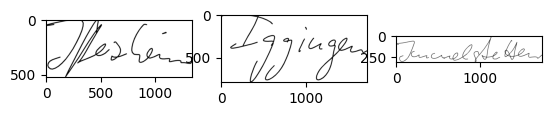

Handler 1: ../../data/handwriting/Unipen/train_r01_v07/include/anj
(341, 3)
Canvas: (91, 244)
(366, 3)
Canvas: (76, 269)
(348, 3)
Canvas: (77, 212)


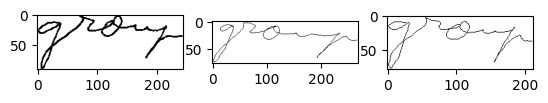

Handler 2: ../../data/handwriting/Unipen/train_r01_v07/include/apa
(841, 3)
Canvas: (32, 452)
(638, 3)
Canvas: (37, 352)
(1086, 3)
Canvas: (32, 578)


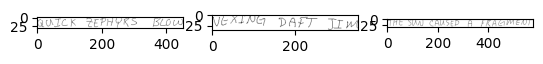

Handler 3: ../../data/handwriting/Unipen/train_r01_v07/include/apb
(617, 3)
Canvas: (1559, 1305)
(1168, 3)
Canvas: (1501, 1641)
(927, 3)
Canvas: (1544, 1553)


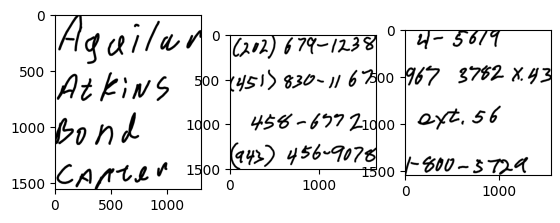

Handler 4: ../../data/handwriting/Unipen/train_r01_v07/include/apc
(576, 3)
Canvas: (932, 883)
(476, 3)
Canvas: (1262, 780)
(737, 3)
Canvas: (1007, 1571)


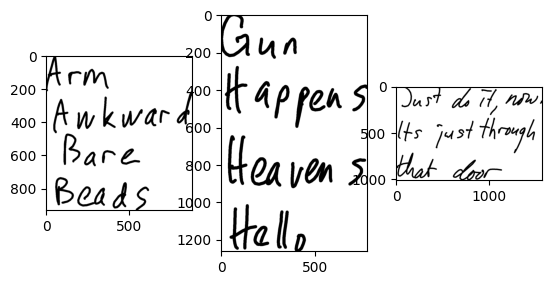

Handler 5: ../../data/handwriting/Unipen/train_r01_v07/include/apd
(350, 3)
Canvas: (1056, 772)
(562, 3)
Canvas: (892, 1167)
(423, 3)
Canvas: (910, 977)


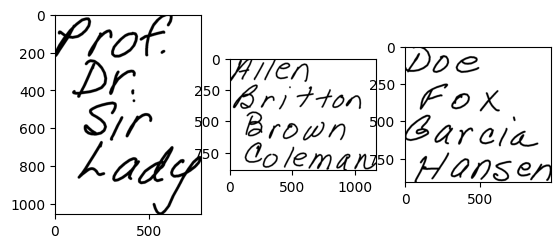

Handler 6: ../../data/handwriting/Unipen/train_r01_v07/include/ape
(679, 3)
Canvas: (1655, 701)
(1386, 3)
Canvas: (1793, 1322)
(739, 3)
Canvas: (634, 1249)


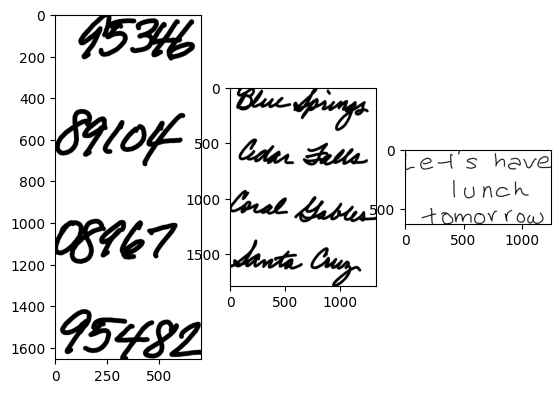

Handler 7: ../../data/handwriting/Unipen/train_r01_v07/include/app
(1305, 3)
Canvas: (60, 674)
(1310, 3)
Canvas: (44, 704)
(765, 3)
Canvas: (48, 444)


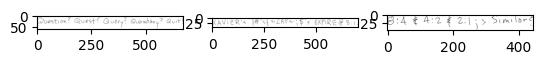

Handler 8: ../../data/handwriting/Unipen/train_r01_v07/include/att
(976, 3)
Canvas: (129, 1653)
(1331, 3)
Canvas: (1333, 3254)
(1303, 3)
Canvas: (172, 1689)


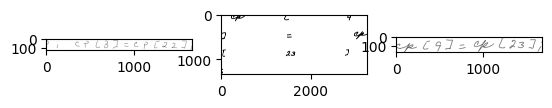

Handler 9: ../../data/handwriting/Unipen/train_r01_v07/include/bba
(1424, 3)
Canvas: (734, 13061)
(2004, 3)
Canvas: (787, 19334)
(1989, 3)
Canvas: (878, 20318)


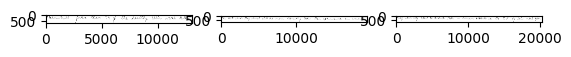

Handler 10: ../../data/handwriting/Unipen/train_r01_v07/include/bbb
(4031, 3)
Canvas: (779, 30713)
(669, 3)
Canvas: (679, 5280)
(4904, 3)
Canvas: (703, 39059)


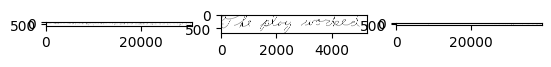

Handler 11: ../../data/handwriting/Unipen/train_r01_v07/include/bbc
(4061, 3)
Canvas: (713, 22450)
(4281, 3)
Canvas: (680, 26025)
(4949, 3)
Canvas: (745, 28169)


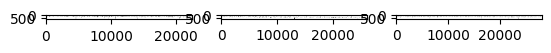

Handler 12: ../../data/handwriting/Unipen/train_r01_v07/include/bbd
(4151, 3)
Canvas: (728, 25545)
(4696, 3)
Canvas: (669, 27659)
(2661, 3)
Canvas: (619, 18439)


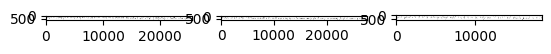

Handler 13: ../../data/handwriting/Unipen/train_r01_v07/include/cea
(2731, 3)
Canvas: (543, 8692)
(1194, 3)
Canvas: (494, 8105)
(3926, 3)
Canvas: (532, 9927)


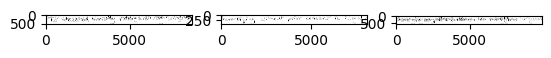

Handler 14: ../../data/handwriting/Unipen/train_r01_v07/include/ceb
(317, 3)
Canvas: (355, 2046)
(13, 3)
Canvas: (230, 54)
(1335, 3)
Canvas: (415, 4633)


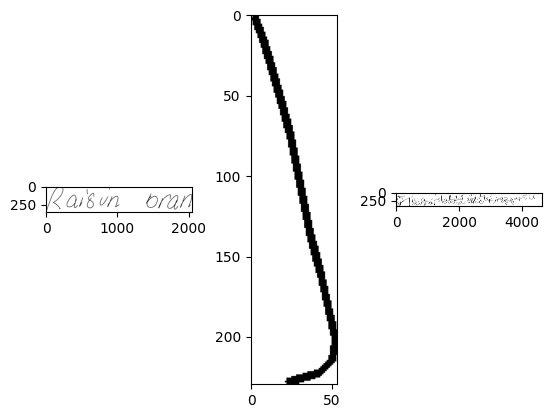

Handler 15: ../../data/handwriting/Unipen/train_r01_v07/include/cec
(5044, 3)
Canvas: (1730, 9213)
(811, 3)
Canvas: (500, 6641)
(1339, 3)
Canvas: (914, 8865)


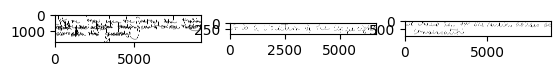

Handler 16: ../../data/handwriting/Unipen/train_r01_v07/include/ced
(1481, 3)
Canvas: (597, 2860)
(388, 3)
Canvas: (292, 1853)
(472, 3)
Canvas: (651, 1841)


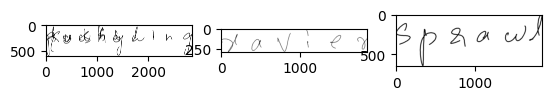

Handler 17: ../../data/handwriting/Unipen/train_r01_v07/include/cee
(2534, 3)
Canvas: (504, 1688)
(1764, 3)
Canvas: (419, 1695)
(603, 3)
Canvas: (498, 1167)


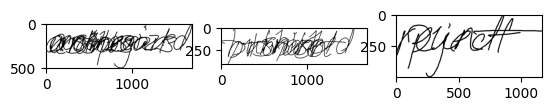

Handler 18: ../../data/handwriting/Unipen/train_r01_v07/include/dar
(2222, 3)
Canvas: (1163, 15491)
(5205, 3)
Canvas: (3773, 15938)
(4265, 3)
Canvas: (3888, 16371)


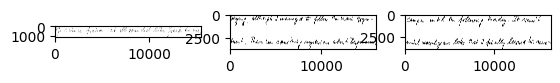

Handler 19: ../../data/handwriting/Unipen/train_r01_v07/include/gmd
(30, 3)
Canvas: (71, 338)
(24, 3)
Canvas: (75, 17)
(105, 3)
Canvas: (54, 107)


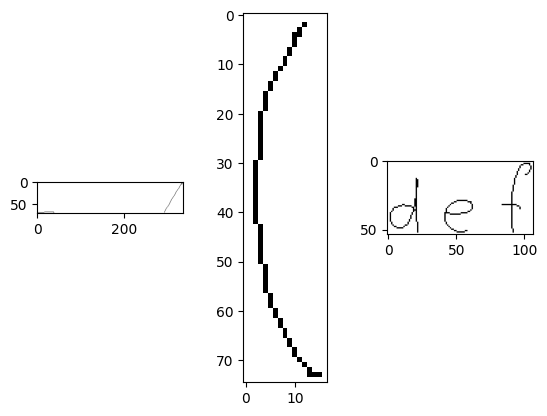

Handler 20: ../../data/handwriting/Unipen/train_r01_v07/include/imt
(256, 3)
Canvas: (77, 193)
(279, 3)
Canvas: (47, 210)
(236, 3)
Canvas: (34, 165)


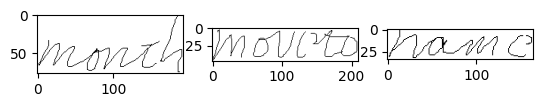

Handler 21: ../../data/handwriting/Unipen/train_r01_v07/include/int
(344, 3)
Canvas: (98, 268)
(231, 3)
Canvas: (157, 174)
(343, 3)
Canvas: (115, 243)


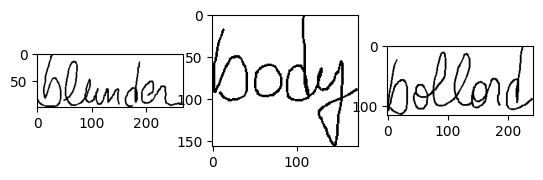

Handler 22: ../../data/handwriting/Unipen/train_r01_v07/include/lex
(115, 3)
Canvas: (341, 863)
(222, 3)
Canvas: (352, 2064)
(83, 3)
Canvas: (405, 654)


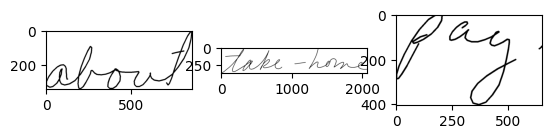

Handler 23: ../../data/handwriting/Unipen/train_r01_v07/include/par
(194, 3)
Canvas: (357, 935)
(372, 3)
Canvas: (1703, 961)
(586, 3)
Canvas: (828, 1264)


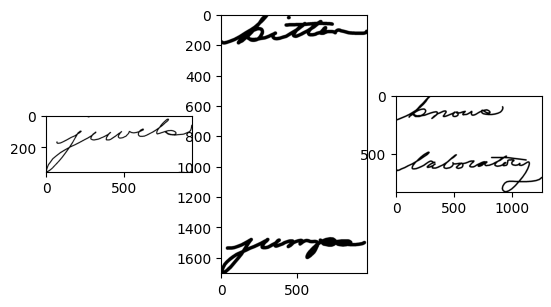

Handler 24: ../../data/handwriting/Unipen/train_r01_v07/include/pcl
(1045, 3)
Canvas: (144, 317)
(1761, 3)
Canvas: (152, 518)
(1310, 3)
Canvas: (193, 382)


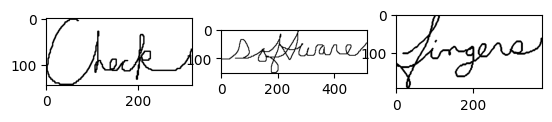

Handler 25: ../../data/handwriting/Unipen/train_r01_v07/include/pri
(2848, 3)
Canvas: (652, 7034)
(1988, 3)
Canvas: (225, 5168)
(515, 3)
Canvas: (253, 1237)


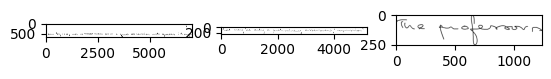

Handler 26: ../../data/handwriting/Unipen/train_r01_v07/include/rim
(1233, 3)
Canvas: (671, 1961)
(1113, 3)
Canvas: (696, 1908)
(1200, 3)
Canvas: (707, 2230)


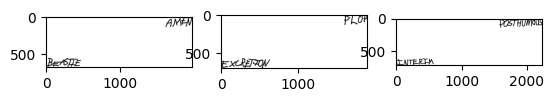

Handler 27: ../../data/handwriting/Unipen/train_r01_v07/include/scr
(1712, 3)
Canvas: (873, 7143)
(1272, 3)
Canvas: (791, 7170)
(1831, 3)
Canvas: (1166, 6422)


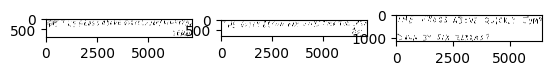

Handler 28: ../../data/handwriting/Unipen/train_r01_v07/include/uqb
(38, 3)
Canvas: (13, 120)
(162, 3)
Canvas: (330, 1151)
(122, 3)
Canvas: (200, 522)


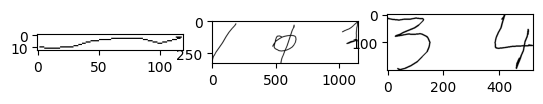

Handler 29: ../../data/handwriting/Unipen/train_r01_v07/include/hpb
(106, 3)
Canvas: (44, 56)
(530, 3)
Canvas: (67, 116)
(373, 3)
Canvas: (57, 122)


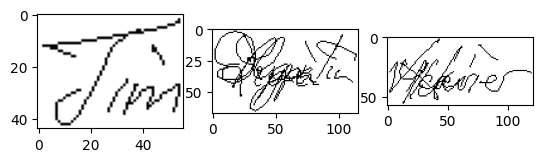

Handler 30: ../../data/handwriting/Unipen/train_r01_v07/include/hpp
(820, 3)
Canvas: (1099, 1064)
(1635, 3)
Canvas: (991, 1435)
(885, 3)
Canvas: (641, 1047)


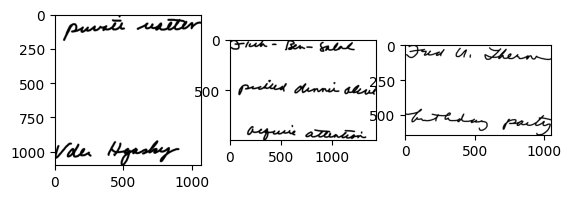

Handler 31: ../../data/handwriting/Unipen/train_r01_v07/include/huj
(967, 3)
Canvas: (268, 695)
(1730, 3)
Canvas: (164, 1519)
(1593, 3)
Canvas: (182, 1229)


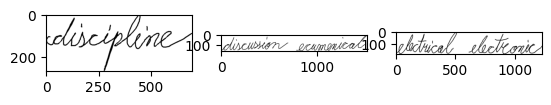

Handler 32: ../../data/handwriting/Unipen/train_r01_v07/include/tos
(591, 3)
Canvas: (85, 69)
(384, 3)
Canvas: (60, 46)
(465, 3)
Canvas: (67, 64)


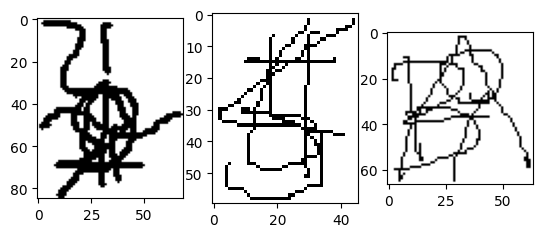

Handler 33: ../../data/handwriting/Unipen/train_r01_v07/include/kai
(124, 3)
Canvas: (95, 82)
(66, 3)
Canvas: (83, 64)
(66, 3)
Canvas: (87, 60)


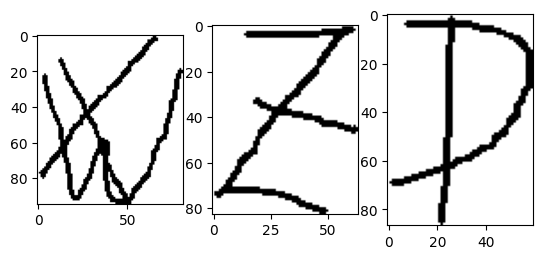

Handler 34: ../../data/handwriting/Unipen/train_r01_v07/include/kar
(210, 3)
Canvas: (755, 1842)
(279, 3)
Canvas: (1136, 2077)
(459, 3)
Canvas: (1298, 4239)


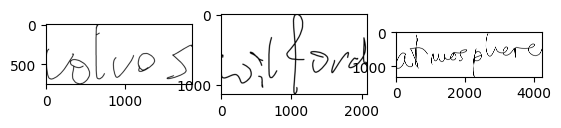

Handler 35: ../../data/handwriting/Unipen/train_r01_v07/include/lav
(30, 3)
Canvas: (223, 215)
(29, 3)
Canvas: (270, 332)
(33, 3)
Canvas: (298, 276)


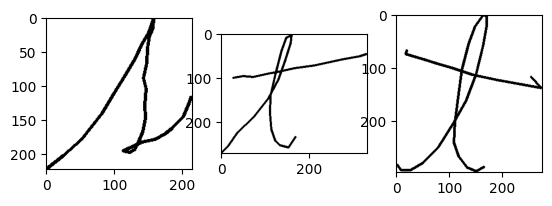

Handler 36: ../../data/handwriting/Unipen/train_r01_v07/include/lou
(418, 3)
Canvas: (41, 89)
(788, 3)
Canvas: (52, 141)
(82, 3)
Canvas: (55, 49)


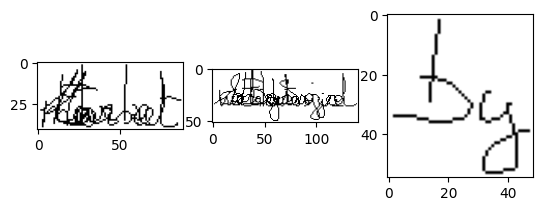

Handler 37: ../../data/handwriting/Unipen/train_r01_v07/include/mot
(101, 3)
Canvas: (1432, 1600)
(100, 3)
Canvas: (744, 846)
(49, 3)
Canvas: (684, 306)


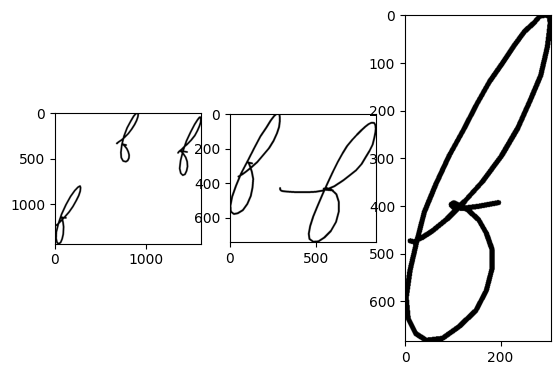

Handler 38: ../../data/handwriting/Unipen/train_r01_v07/include/pap
(141, 3)
Canvas: (290, 1006)
(279, 3)
Canvas: (452, 1504)
(205, 3)
Canvas: (530, 1196)


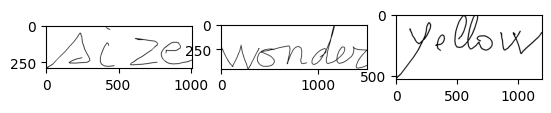

Handler 39: ../../data/handwriting/Unipen/train_r01_v07/include/phi
(506, 3)
Canvas: (436, 1257)
(38, 3)
Canvas: (373, 482)
(216, 3)
Canvas: (453, 1261)


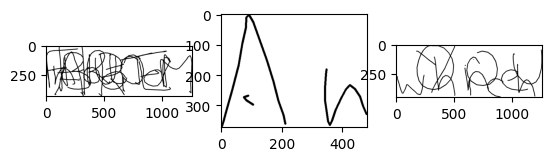

Handler 40: ../../data/handwriting/Unipen/train_r01_v07/include/sta
(211, 3)
Canvas: (260, 1151)
(269, 3)
Canvas: (258, 947)
(327, 3)
Canvas: (276, 1099)


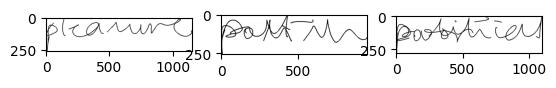

Handler 41: ../../data/handwriting/Unipen/train_r01_v07/include/syn
(55, 3)
Canvas: (238, 350)
(75, 3)
Canvas: (277, 137)
(51, 3)
Canvas: (278, 235)


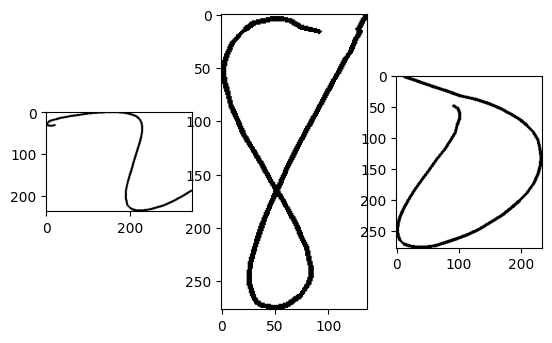

Handler 42: ../../data/handwriting/Unipen/train_r01_v07/include/val
(21, 3)
Canvas: (466, 167)
(42, 3)
Canvas: (453, 667)
(20, 3)
Canvas: (434, 113)


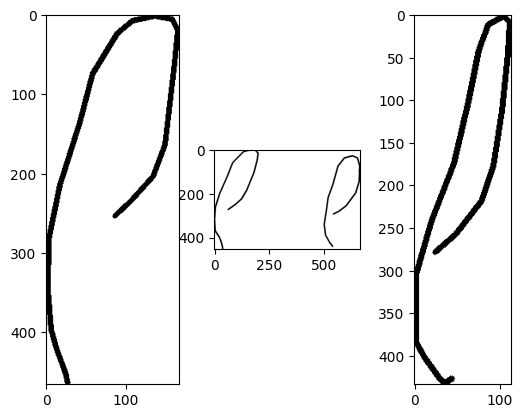

Handler 43: ../../data/handwriting/Unipen/train_r01_v07/include/ugi
(84, 3)
Canvas: (85, 202)
(121, 3)
Canvas: (97, 272)
(174, 3)
Canvas: (121, 335)


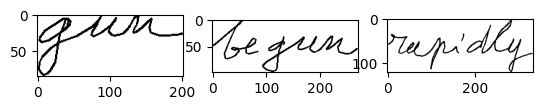

Handler 44: ../../data/handwriting/Unipen/train_r01_v07/include/art
(28, 3)
Canvas: (80, 40)
(23, 3)
Canvas: (73, 28)
(25, 3)
Canvas: (43, 32)


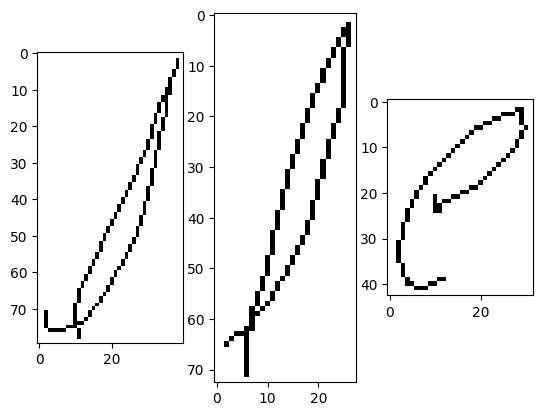

Handler 45: ../../data/handwriting/Unipen/train_r01_v07/include/aga
(1122, 3)
Canvas: (410, 4820)
(183, 3)
Canvas: (216, 180)
(128, 3)
Canvas: (219, 142)


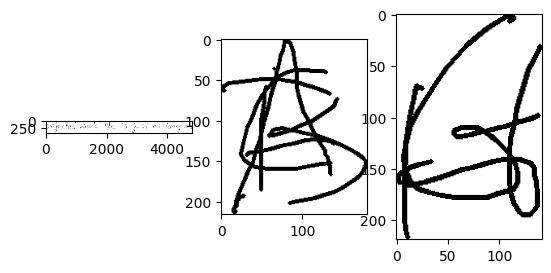

Handler 46: ../../data/handwriting/Unipen/train_r01_v07/include/atu
(660, 3)
Canvas: (635, 3607)
(929, 3)
Canvas: (906, 5522)
(950, 3)
Canvas: (1945, 4503)


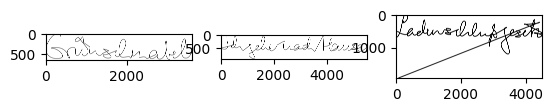

Handler 47: ../../data/handwriting/Unipen/train_r01_v07/include/nic
(345, 3)
Canvas: (978, 1892)
(1033, 3)
Canvas: (874, 2304)
(994, 3)
Canvas: (792, 2230)


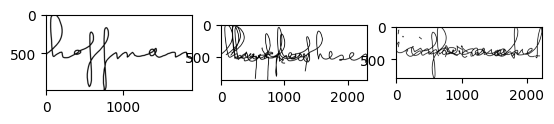

Handler 48: ../../data/handwriting/Unipen/train_r01_v07/include/sie
(227, 3)
Canvas: (1108, 3407)
(293, 3)
Canvas: (225, 688)
(270, 3)
Canvas: (213, 731)


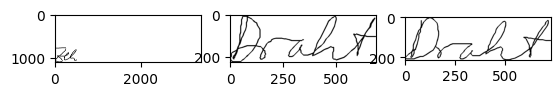

In [142]:
import matplotlib.pyplot as plt
from random import randint

for i, handler in enumerate(handlers):
    print(f"Handler {i}: {handler.handler_root}")
    strokes = handler.strokes

    n = randint(0, len(strokes) - 3)

    fig, axs = plt.subplots(1, 3)

    for i, stroke in enumerate(strokes[n:n+3]):
        print(stroke.shape)
        
        image = create_image(stroke, compute_reasonable_stroke_size(stroke))

        axs[i].imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.show()

Testing problematic providers

Missing key values {'X_POINTS_PER_INCH', 'Y_POINTS_PER_INCH'} on file ../../data/handwriting/Unipen/train_r01_v07/include/ced/ced3.doc
Scanning ../../data/handwriting/Unipen/train_r01_v07/include/ced/data
Strokes: 564
(363, 3)
Canvas: (259, 1561)
(505, 3)
Canvas: (385, 1890)
(337, 3)
Canvas: (273, 1485)


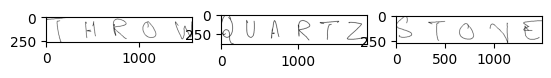

In [143]:
unipen_root = "../../data/handwriting/Unipen/train_r01_v07/include"
provider = "ced"

handler = SingleDocFileHandler(os.path.join(unipen_root, provider))
handler.create_strokes()
print(f"Strokes: {len(handler.strokes)}")

import matplotlib.pyplot as plt
from random import randint

strokes = handler.strokes

n = randint(0, len(strokes) - 4)

fig, axs = plt.subplots(1, 3)

for i, stroke in enumerate(strokes[n:n+3]):
    print(stroke.shape)
    image = create_image(stroke, compute_reasonable_stroke_size(stroke))

    axs[i].imshow(image, cmap='gray', vmin=0, vmax=255)
plt.show()